In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt 

In [36]:
df = pd.read_csv('../data/preprocessed/layer1/matches_stats_data_1.csv')
result_cols = ['result_A', 'result_D', 'result_H']

In [37]:
df = df[[col for col in df if col not in result_cols]+[col for col in result_cols if col in df]]
df['season'] = df['season'].apply(lambda x:  int(x[2:4]) - 19)
df['result_H'] = df['result_H'].apply(lambda x: 1 if x else 0)
df['result_A'] = df['result_A'].apply(lambda x: 1 if x else 0)
df['result_D'] = df['result_D'].apply(lambda x: 1 if x else 0)
df = df.drop(columns='round')

In [38]:
home_columns = ['result_H',
                'gf','ga', 
                'h_xg',
                'h_xga', 'h_standard sot', 'h_kp', 'h_xa', 'h_poss_x',
                'h_touches att pen', 'h_carries prgdist', 'h_progressive passing dist',
                'h_tackles tklw', 'h_challenges tkl%', 'h_saves',
                'h_strength_overall_home', 'h_overall_rating', 'h_attack_rating',
                'h_midfield_rating', 'h_defence_rating', 'h_avg_age','soh']
away_columns = ['result_A',
                'ga','gf',
                'a_xg', 
                'a_xga','a_standard sot', 'a_kp', 'a_xa', 'a_poss_x', 
                'a_touches att pen','a_carries prgdist', 'a_progressive passing dist', 
                'a_tackles tklw','a_challenges tkl%', 'a_saves',
                'a_strength_overall_away', 'a_overall_rating', 'a_attack_rating',
                'a_midfield_rating', 'a_defence_rating', 'a_avg_age', 'soa']

bet_columns = ['b365h', 'b365d', 'b365a']

In [39]:
df[(df['hometeam']=='AVL') & (df['awayteam']=='ARS') & (df['season']==1)][result_cols].values

array([[0, 0, 1]])

In [40]:
Home_run = pd.read_csv('../data/preprocessed/layer2/fts_home_0.csv')
Home_run['season'] = Home_run['season'].apply(lambda x:  int(x[2:4]) - 19)
# Home_run = Home_run.rename(columns={'team':'hometeam'})
Home_run = Home_run.set_index(['team','opponent_team']).sort_index()


Away_run = pd.read_csv('../data/preprocessed/layer2/fts_away_0.csv')
Away_run['season'] = Away_run['season'].apply(lambda x:  int(x[2:4]) - 19)
# Away_run = Away_run.rename(columns={'team':'awayteam'})
Away_run = Away_run.set_index(['team','opponent_team']).sort_index()


Home_sub = pd.read_csv('../data/preprocessed/layer2/fts_home_1.csv')
Home_sub['season'] = Home_sub['season'].apply(lambda x:  int(x[2:4]) - 19)
Home_sub = Home_sub.set_index(['team','opponent_team']).sort_index()


Away_sub = pd.read_csv('../data/preprocessed/layer2/fts_away_1.csv')
Away_sub['season'] = Away_sub['season'].apply(lambda x:  int(x[2:4]) - 19)
Away_sub = Away_sub.set_index(['team','opponent_team']).sort_index()

In [41]:
ss20 = df[df['season']==1]
hr20 = Home_run[Home_run['season']==1].drop(columns='season')
hs20 = Home_sub[Home_sub['season']==1].drop(columns='season')
ar20 = Away_run[Away_run['season']==1].drop(columns='season')
as20 = Away_sub[Away_sub['season']==1].drop(columns='season')

In [42]:
def prepare_data(hr:pd.DataFrame, ar:pd.DataFrame,
                hsub: pd.DataFrame, asub: pd.DataFrame, prematch: int =5):
    match_list = hr.index.drop_duplicates().values.tolist()
    h_team_data = {}
    a_team_data = {}
    final_dict = {}
    for team,_ in match_list:
        h_team_data[team]=[]
        a_team_data[team]=[]
        final_dict[team] = {'HOME':{}, 'AWAY':{}}
    for hometeam, awayteam in match_list:
        h_team_data[hometeam].append(np.hstack((hr.loc[hometeam, awayteam].iloc[:,1:-2].mean().values,hsub.loc[hometeam, awayteam].iloc[:,2:-2].mean().values)))
        a_team_data[awayteam].append(np.hstack((ar.loc[awayteam, hometeam].iloc[:,1:-2].mean().values,asub.loc[awayteam, hometeam].iloc[:,2:-2].mean().values)))
    
    for team, matches in h_team_data.items():
        for idx in range(1,len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = hr[hr['round']==int(pre_match_data[-1][0])].loc[team].index.unique().values[0]
            pre_match_data = np.vstack(pre_match_data)
            final_dict[team]['HOME'][pre_match_data_key] = pre_match_data[:-1, 1:]
            
    for team, matches in a_team_data.items():
        for idx in range(1,len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = ar[ar['round']==int(pre_match_data[-1][0])].loc[team].index.unique().values[0]
            pre_match_data = np.vstack(pre_match_data)
            final_dict[team]['AWAY'][pre_match_data_key] = pre_match_data[:-1, 1:]
            
    return final_dict

In [43]:
ss20[(ss20['hometeam']=='MCI') & (ss20['awayteam']=='MUN')][result_cols+bet_columns]

,result_A,result_D,result_H,b365h,b365d,b365a
270,1,0,0,1.45,4.5,7.0


In [44]:
tmp_dict = prepare_data(hr20, ar20, hs20, as20)


In [45]:
tmp_dict['ARS']['HOME']['CHE']

array([[-4.08374363e-01, -2.02512839e-01, -2.61072094e-02,
        -2.73105922e-01, -4.14309544e-01, -8.71624255e-02,
        -2.82384602e-01, -3.44379511e-02,  8.91508214e-02,
        -2.02512839e-01,  1.10749037e+00,  5.71526206e-01,
         5.24686798e-01,  1.41122924e-01,  4.44396102e-01,
         2.50814947e-01],
       [-4.30388752e-01, -2.02512839e-01,  3.32195562e-02,
        -4.00176767e-01, -5.02421436e-01, -3.07090508e-01,
        -1.35635480e-01, -4.24619529e-02,  2.20333266e+00,
         1.19681382e+00,  6.29806191e-01,  1.54667117e+00,
         1.14390451e+00,  8.77322182e-01,  1.05750622e-01,
         3.24679301e-01],
       [-4.26719687e-01, -2.02512839e-01, -6.69260523e-02,
        -2.64461646e-01, -4.58269508e-01, -3.40812814e-01,
        -2.91689623e-01, -3.51512929e-02, -2.10882633e-03,
        -2.02512839e-01,  9.84522167e-01,  1.40602096e+00,
         5.78402070e-01,  1.44713585e+00,  3.00587548e-01,
        -1.24924834e-01]])

In [46]:
def create_X_y(final_dict: dict, org_data: pd.DataFrame):

    X =np.empty((0,35))
    y = []
    data_dict = {}
    for team_idx in final_dict.keys():
        for opponent, match_data in final_dict[team_idx]['HOME'].items():
            match_dict = {}
            team1_data = match_data
            try:
                team2_data = final_dict[opponent]['AWAY'][team_idx]
            except KeyError:
                continue
            away, _, home, h,d,a = org_data[(org_data['hometeam']==team_idx) & (org_data['awayteam']==opponent)][result_cols+bet_columns].values.tolist()[0]
            
            weights_1 = np.ones(team1_data.shape[0])/(team1_data.shape[0])
            weights_2 = np.ones(team2_data.shape[0])/(team2_data.shape[0])
            team1_prematch = np.dot(weights_1, team1_data).reshape(-1)
            team2_prematch = np.dot(weights_2, team2_data).reshape(-1)
            prematch = np.concatenate((team1_prematch, team2_prematch))
            prematch = np.concatenate((prematch, np.array([h,d,a])))
            
            this_match_res = 0 if home == 1 else 1 if away == 1 else 1
            X = np.vstack((X, prematch))
            y.append(this_match_res)
            
            match_dict['x'] = prematch
            match_dict['y'] = this_match_res
            data_dict[team_idx+opponent] = match_dict
    y = np.asarray(y)
    return data_dict, X, y

In [47]:
data_dict, X, y = create_X_y(tmp_dict,ss20)

In [48]:
data_dict

{'ARSNEW': {'x': array([-4.19337878e-01, -2.02512839e-01,  5.64450070e-02, -3.46248839e-01,
         -4.66741673e-01, -3.26098578e-01, -1.33855664e-01, -1.33569019e-01,
          5.33090983e-01,  1.73813498e-02,  7.84698834e-01,  4.98468721e-01,
          4.85892436e-01,  5.20428889e-01,  1.65244024e-01, -2.14692546e-01,
         -4.22618968e-01, -2.02512839e-01, -2.04355953e-01, -4.04356528e-01,
         -5.08366702e-01, -3.58838292e-01, -2.91421703e-01, -4.57200647e-02,
          1.88015440e-01, -2.02512839e-01,  6.22606302e-02,  1.12397317e-01,
          2.99381077e-01, -1.91846546e-02, -1.95364909e-02, -5.05329603e-03,
          1.40000000e+00,  4.50000000e+00,  8.00000000e+00]),
  'y': 0},
 'AVLBHA': {'x': array([-0.44414775, -0.20251284, -0.18554789, -0.40714621, -0.48368686,
         -0.33210733, -0.21177827, -0.06879831,  1.70900957,  0.99691001,
          0.46427207,  0.8640249 ,  1.22895369,  0.79374951,  1.10490498,
          0.10642269, -0.41897388, -0.20251284, -0.19698858

In [49]:
y.shape

(320,)

In [50]:
def handle_data(ss: int, prematch:int = 5, seq: bool = False):
    global df, Home_run, Home_sub, Away_run, Away_sub
    tmpss=ss-19
    sscheck = df[df['season']==tmpss]
    hrss = Home_run[Home_run['season']==tmpss].drop(columns='season')
    hsss = Home_sub[Home_sub['season']==tmpss].drop(columns='season')
    arss = Away_run[Away_run['season']==tmpss].drop(columns='season')
    asss = Away_sub[Away_sub['season']==tmpss].drop(columns='season')
    finalss = prepare_data(hrss, arss,hsss, asss,prematch=prematch)
    _, X, y = create_X_y(finalss, sscheck)
    print(X.shape, y.shape)
    if seq:
        np.save(f'Layer_2/Data/inputs{ss}_{ss+1}_seq.npy',X)
        np.save(f'Layer_2/Data/outputs{ss}_{ss+1}_seq.npy',y)
    else:
        np.save(f'Layer_2/Data/Playerinputs{ss}_{ss+1}_NH.npy',X)
        np.save(f'Layer_2/Data/Playeroutputs{ss}_{ss+1}_NH.npy',y)

In [51]:
handle_data(21)
handle_data(22)
handle_data(23)
handle_data(20)

(318, 35) (318,)
(327, 35) (327,)
(333, 35) (333,)
(320, 35) (320,)


In [52]:
input_21 = np.load('Layer_2/Data/Playerinputs21_22_NH.npy', allow_pickle=True)
y_21 = np.load('Layer_2/Data/Playeroutputs21_22_NH.npy', allow_pickle=True)
input_22 = np.load('Layer_2/Data/Playerinputs22_23_NH.npy', allow_pickle=True)
y_22 = np.load('Layer_2/Data/Playeroutputs22_23_NH.npy', allow_pickle=True)
input_23 = np.load('Layer_2/Data/Playerinputs23_24_NH.npy', allow_pickle=True)
y_23 = np.load('Layer_2/Data/Playeroutputs23_24_NH.npy', allow_pickle=True)


INPUTS = np.vstack((input_21,input_22))
# INPUTS = np.vstack((INPUTS, input_22_1_1))
LABELS = np.concatenate((y_21,y_22))
# LABELS = np.concatenate((LABELS, y_22))
train_X, test_X, train_y, test_y = train_test_split(INPUTS, LABELS, test_size = 0.2, shuffle = True)

In [53]:
def cal_profit(y_predict):
    global input_23, y_23
    bet_rate = input_23[:,-3:]
    original = 2*(y_predict.shape[0])
    money = original
    for i in range(y_predict.shape[0]):
        if y_predict[i] == y_23[i]:
            money+= (bet_rate[i][y_predict[i]]-1)*2
        else:
            money-=2
    return money/original *100 - 100

0.6666666666666666


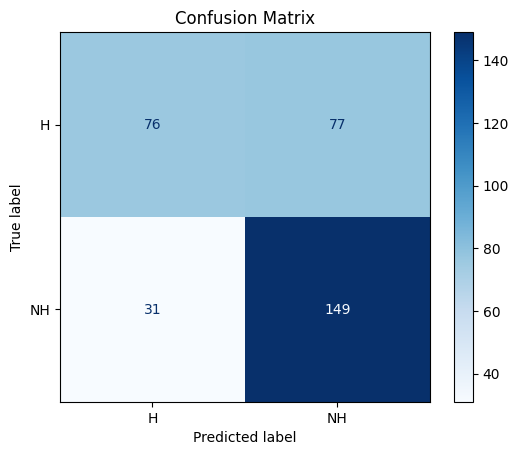

0.6756756756756757

In [54]:
svc_ovo = SVC(kernel='linear')
svc_ovo.fit(INPUTS, LABELS)
y_predict = svc_ovo.predict(input_23)
print(accuracy_score(LABELS, svc_ovo.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
#print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)

1.0


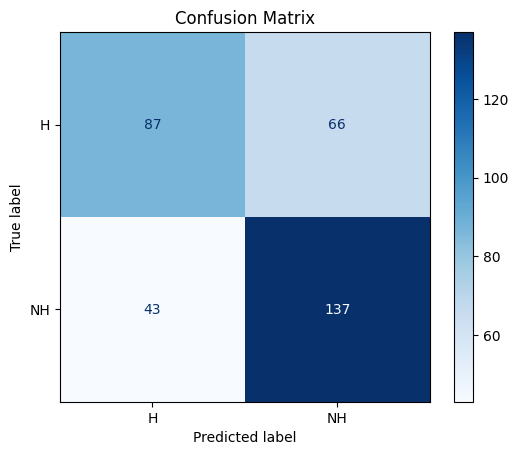

0.6726726726726727

In [55]:
rf_clf = RandomForestClassifier(criterion='entropy', random_state=42)
rf_clf.fit(INPUTS, LABELS)
y_predict = rf_clf.predict(input_23)
print(accuracy_score(LABELS, rf_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
#print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)


0.9627906976744186


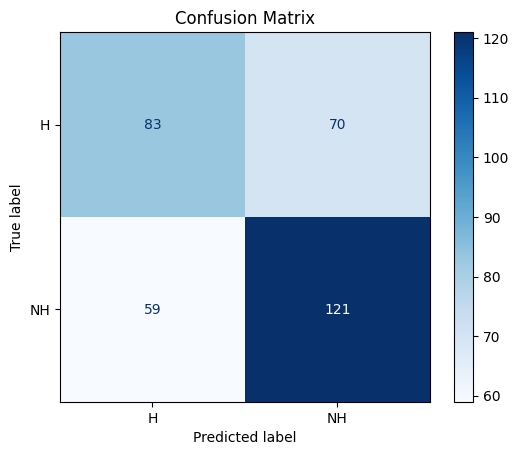

0.6126126126126126

In [56]:
xGboost_clf = GradientBoostingClassifier(random_state=42)
xGboost_clf.fit(INPUTS, LABELS)
y_predict = xGboost_clf.predict(input_23)
print(accuracy_score(LABELS, xGboost_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "NH"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
#print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)


In [57]:
import pickle

# Save the model
with open('Layer_2/Model/H_NH/SVM.pkl', 'wb') as f:
    pickle.dump(svc_ovo, f)

with open('Layer_2/Model/H_NH/RandomForest.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)
    
with open('Layer_2/Model/H_NH/xGBoost.pkl', 'wb') as f:
    pickle.dump(xGboost_clf, f)
